# Milestone Project

Dataset Info: The dataset used for this analysis is publicly available on Kaggle and can be accessed at (https:The data set is collected from Kaggle.com (https://www.kaggle.com/datasets/preethamgouda/financial-risk). However, this dataset is public accessed therefore it may convey some bias or inaccurate information. Thus, conclusions should be treated with circumspection, and the generalizability of the conclusions ascertained perhaps, may need additional verification for their reliability.

### Importing libraries

In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

In [34]:
# Load the dataset
file_path = 'financial_risk_assessment.csv'
df = pd.read_csv(file_path)

In [35]:
# Initial Data Exploration
print("First few rows of the dataset:")
print(df.head())

First few rows of the dataset:
   Age      Gender Education Level Marital Status   Income  Credit Score  \
0   49        Male             PhD       Divorced  72799.0         688.0   
1   57      Female      Bachelor's        Widowed      NaN         690.0   
2   21  Non-binary        Master's         Single  55687.0         600.0   
3   59        Male      Bachelor's         Single  26508.0         622.0   
4   25  Non-binary      Bachelor's        Widowed  49427.0         766.0   

   Loan Amount Loan Purpose Employment Status  Years at Current Job  \
0      45713.0     Business        Unemployed                    19   
1      33835.0         Auto          Employed                     6   
2      36623.0         Home          Employed                     8   
3      26541.0     Personal        Unemployed                     2   
4      36528.0     Personal        Unemployed                    10   

  Payment History  Debt-to-Income Ratio  Assets Value  Number of Dependents  \
0     

In [36]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    15000 non-null  int64  
 1   Gender                 15000 non-null  object 
 2   Education Level        15000 non-null  object 
 3   Marital Status         15000 non-null  object 
 4   Income                 12750 non-null  float64
 5   Credit Score           12750 non-null  float64
 6   Loan Amount            12750 non-null  float64
 7   Loan Purpose           15000 non-null  object 
 8   Employment Status      15000 non-null  object 
 9   Years at Current Job   15000 non-null  int64  
 10  Payment History        15000 non-null  object 
 11  Debt-to-Income Ratio   15000 non-null  float64
 12  Assets Value           12750 non-null  float64
 13  Number of Dependents   12750 non-null  float64
 14  City                   15000 non

In [37]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
                Age         Income  Credit Score   Loan Amount  \
count  15000.000000   12750.000000  12750.000000  12750.000000   
mean      43.452667   69933.398510    699.109098  27450.010902   
std       14.910732   29163.626207     57.229465  12949.940135   
min       18.000000   20005.000000    600.000000   5000.000000   
25%       31.000000   44281.500000    650.000000  16352.500000   
50%       43.000000   69773.000000    699.000000  27544.000000   
75%       56.000000   95922.750000    748.000000  38547.500000   
max       69.000000  119997.000000    799.000000  49998.000000   

       Years at Current Job  Debt-to-Income Ratio   Assets Value  \
count          15000.000000          15000.000000   12750.000000   
mean               9.476267              0.350438  159741.497176   
std                5.769707              0.143919   80298.115832   
min                0.000000              0.100004   20055.000000   
25%                4.000000              0.2

### Data Missing Value Check
It's essential to check for missing values as they can impact the reliability of our analysis. Identifying and handling missing data correctly ensures accurate modeling and insights.


### Data missing value check

In [38]:
# Checking for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())


Missing Values per Column:
Age                         0
Gender                      0
Education Level             0
Marital Status              0
Income                   2250
Credit Score             2250
Loan Amount              2250
Loan Purpose                0
Employment Status           0
Years at Current Job        0
Payment History             0
Debt-to-Income Ratio        0
Assets Value             2250
Number of Dependents     2250
City                        0
State                       0
Country                     0
Previous Defaults        2250
Marital Status Change       0
Risk Rating                 0
dtype: int64


## Data Preprocessing
To ensure the dataset is complete and ready for analysis, we handle missing values as follows:
- Numerical Columns: Numerical features: To address the skewness issue, the missing values of the numerical features a replaced by the median value.
- Categorical Columns: non values are also imputed with the mode for uniformity.

This approach helps to reduce bias while at the same time not introducing complexities that come with artificial distribution distortions.


## Data Preprocessing

In [39]:
# Handle missing values (example: fill numerical NaNs with median, categorical with mode)
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

In [40]:
# Fill missing numerical columns with median values
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

In [41]:
# Fill missing categorical columns with mode values
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [42]:
# Verify no missing values remain
print("\nMissing Values after Imputation:")
print(df.isnull().sum())


Missing Values after Imputation:
Age                      0
Gender                   0
Education Level          0
Marital Status           0
Income                   0
Credit Score             0
Loan Amount              0
Loan Purpose             0
Employment Status        0
Years at Current Job     0
Payment History          0
Debt-to-Income Ratio     0
Assets Value             0
Number of Dependents     0
City                     0
State                    0
Country                  0
Previous Defaults        0
Marital Status Change    0
Risk Rating              0
dtype: int64


### Outlier Treatment
It is specific data points that are unusual and unusual that can be misleading with statistical measures and the predictions of the mode. We employ z-scores to detect outliers by setting limits at a level of three times the standard deviation from the mean. It aids in sustaining data accuracy and protection against influences from anomalous values of data.


In [43]:
# Outlier Detection and Handling
# For example, handling 'Income' and 'Credit Score' outliers using z-scores
from scipy.stats import zscore

In [44]:
# Calculate z-scores and filter out rows with z-score > 3 (can adjust threshold as needed)
z_scores = np.abs(zscore(df[numerical_cols]))
df = df[(z_scores < 3).all(axis=1)]

In [45]:
# One-hot encoding categorical columns
df = pd.get_dummies(df, columns=['Employment Status', 'Loan Purpose'], drop_first=True)


### Feature Engineering
In order to enhance interpretability and comprehensible analysis of features, some of the categorical features including ‘Employment Status’ and ‘Loan Purpose’ are one hot encoded. They enable the assessment of variations in risk across categories and keep the analysis of the measures accurate.


In [46]:
# Creating a new column 'Employment_Status' from one-hot encoded columns
import numpy as np
def determine_employment_status(row):
    if row['Employment Status_Self-employed'] == 1:
        return 'Self-employed'
    elif row['Employment Status_Unemployed'] == 1:
        return 'Unemployed'
    # Add other conditions if more categories exist
    return 'Other'

In [47]:
df['Employment_Status'] = df.apply(determine_employment_status, axis=1)

# Exploratory Data Analysis Part with justifying decision

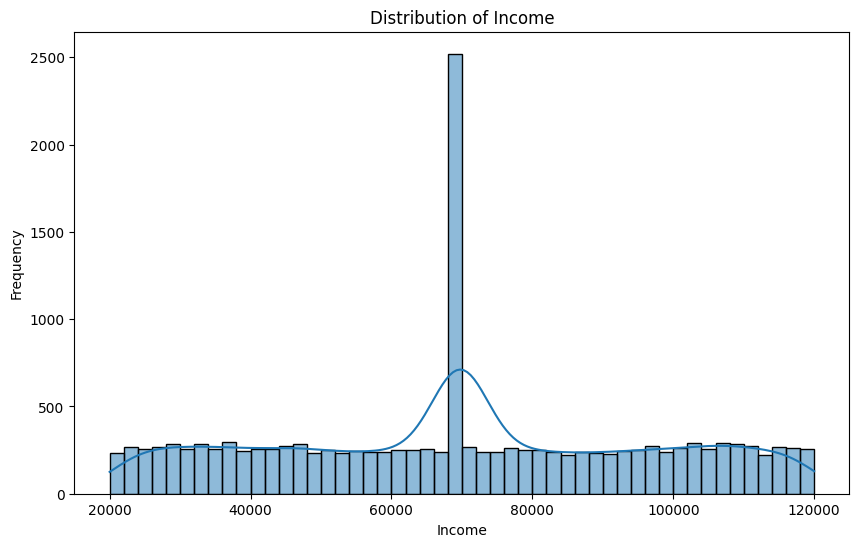

In [48]:
# Distribution plot of Income
plt.figure(figsize=(10, 6))
sns.histplot(df['Income'], bins=50, kde=True)
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

### Distribution of Income
Knowledge of the dispersion of the level of income can help in assessing possible connections with risks within various financial categories.

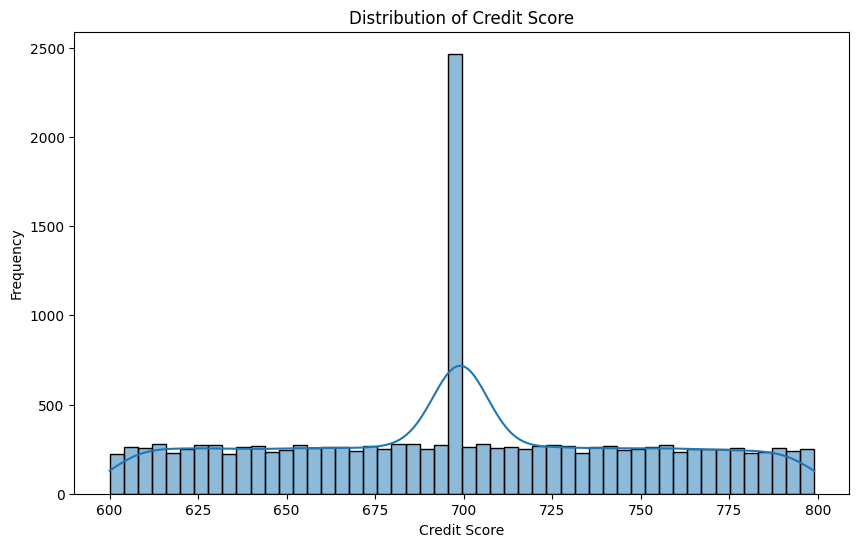

In [49]:
# Distribution plot of Credit Score
plt.figure(figsize=(10, 6))
sns.histplot(df['Credit Score'], bins=50, kde=True)
plt.title('Distribution of Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.show()

#### Credit Score Distribution
Hence analysing the credit scores distribution enables relating the creditworthiness and risk rating levels.


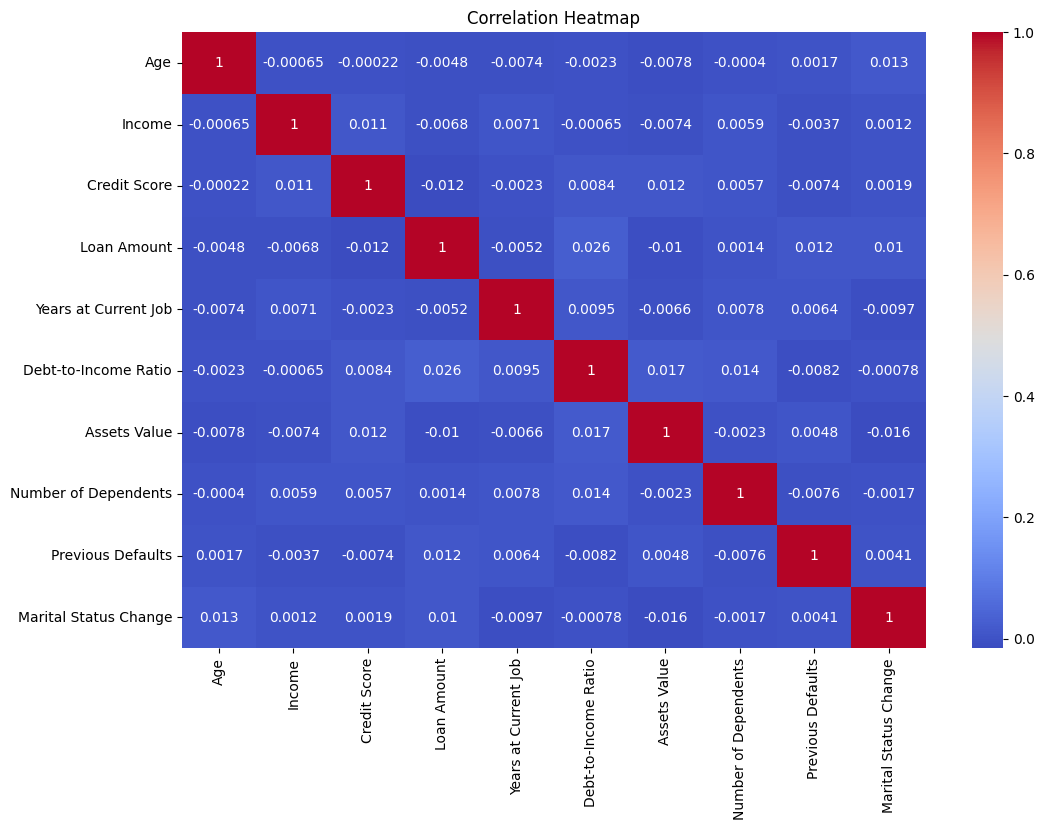

In [50]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=np.number)
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Correlation Heatmap
Correlation heatmap helps in deciding the appropriate relationships being between the numerical values which in turn cautions us about potentials to influence financial risk.

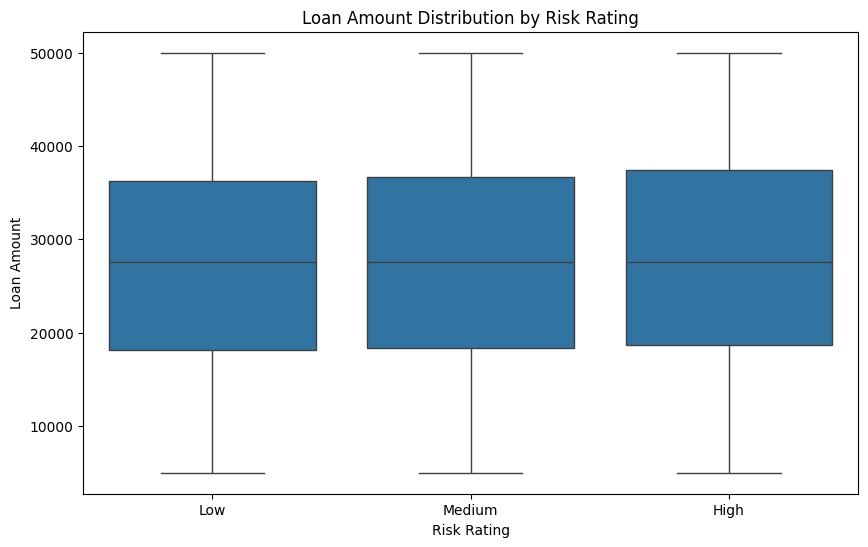

In [51]:
# Boxplot to visualize Loan Amount distribution across Risk Ratings
plt.figure(figsize=(10, 6))
sns.boxplot(x='Risk Rating', y='Loan Amount', data=df)
plt.title('Loan Amount Distribution by Risk Rating')
plt.xlabel('Risk Rating')
plt.ylabel('Loan Amount')
plt.show()

#### Loan Amount Distribution by Risk Rating
This visualization looks at whether loan amounts change from the top or bottom risk ratings, and might be used to compare the trends in lending.

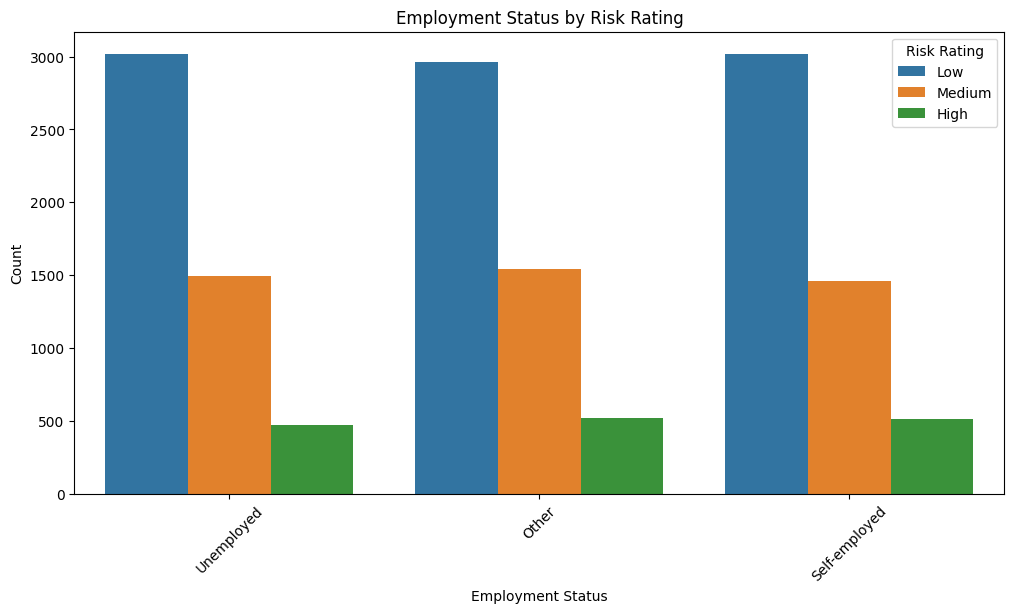

In [52]:
# Bar plot to analyze Employment Status and Risk Rating
plt.figure(figsize=(12, 6))
sns.countplot(x='Employment_Status', hue='Risk Rating', data=df)
plt.title('Employment Status by Risk Rating')
plt.xlabel('Employment Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Employment Status and Risk Rating
The cross-tabulation of employment status and risk rating could reveal degree of risk exposure within the different employment categories.

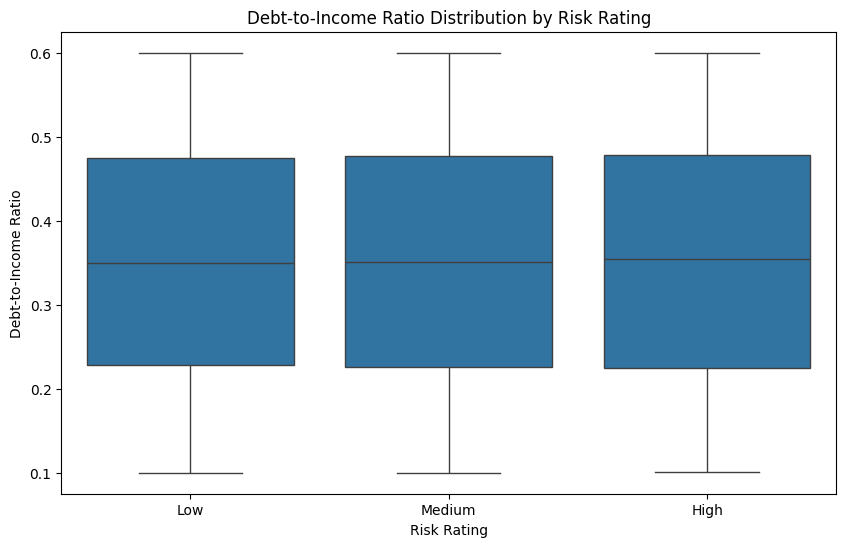

In [53]:
# Visualizing Debt-to-Income Ratio distribution by Risk Rating
plt.figure(figsize=(10, 6))
sns.boxplot(x='Risk Rating', y='Debt-to-Income Ratio', data=df)
plt.title('Debt-to-Income Ratio Distribution by Risk Rating')
plt.xlabel('Risk Rating')
plt.ylabel('Debt-to-Income Ratio')
plt.show()

### DTI by Risk Rating
This Paper will focus on dissecting the debt to income ratio spread across the different risk ratings with an aim of understanding the impact of debt burden on the risk assessment of financial structures.


### Enhanced Multicollinearity Analysis

In [54]:
# Feature Engineering
df['Debt Burden Index'] = df['Loan Amount'] / (df['Income'] + 1)
df['Loan-to-Value Ratio'] = df['Loan Amount'] / (df['Assets Value'] + 1)
df['Normalized Credit Score'] = df['Credit Score'] / df['Age']

In [55]:
# Drop unused columns after engineering
columns_to_drop = ['Age', 'Income', 'Credit Score', 'Loan Amount', 'Debt-to-Income Ratio', 'Assets Value']
df.drop(columns=columns_to_drop, inplace=True)

#### Apply PCA to reduce dimensionality and handle multicollinearity

In [56]:
# Principal Component Analysis (PCA) for numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.select_dtypes(include=np.number))

pca = PCA()
pca_features = pca.fit_transform(scaled_features)

explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.95) + 1  # Components explaining 95% variance
pca_final = PCA(n_components=n_components)
reduced_features = pca_final.fit_transform(scaled_features)

In [57]:
# Compute class weights for imbalanced dataset
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))

# Display class weights
print("Class Weights:", class_weight_dict)

# Resample data using SMOTE (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split on resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)


Class Weights: {'High': 3.3333333333333335, 'Low': 0.5555555555555556, 'Medium': 1.1111111111111112}


In [58]:
# Logistic Regression Model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [59]:
# Predictions and Evaluation
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

In [60]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

        High       0.34      0.50      0.41      2700
         Low       0.33      0.32      0.32      2700
      Medium       0.35      0.20      0.25      2700

    accuracy                           0.34      8100
   macro avg       0.34      0.34      0.33      8100
weighted avg       0.34      0.34      0.33      8100



In [61]:
# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[1346  820  534]
 [1364  864  472]
 [1219  943  538]]


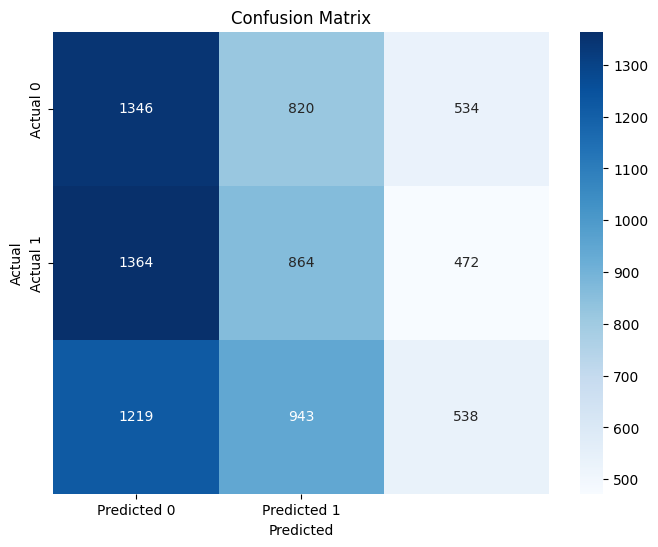

In [62]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Updated ROC-AUC Score: 0.51


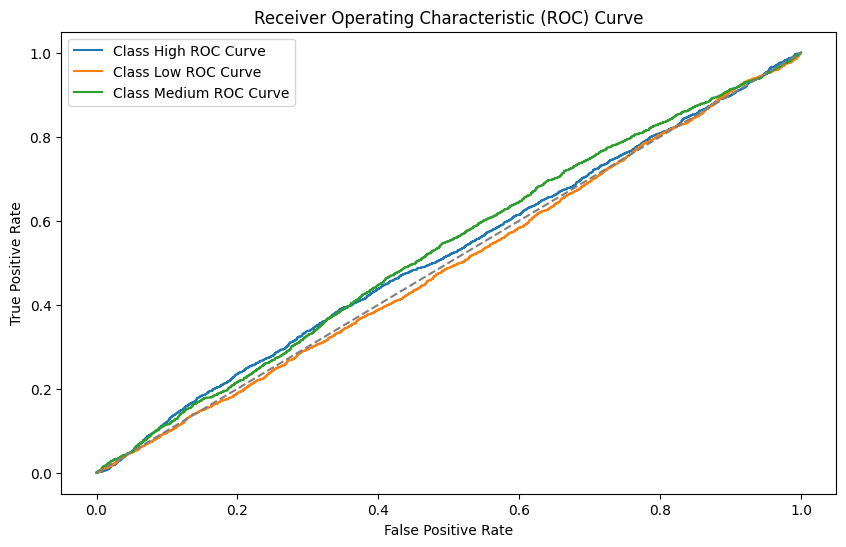

In [63]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test), multi_class='ovr')
print(f"Updated ROC-AUC Score: {roc_auc:.2f}")

fpr = {}
tpr = {}
plt.figure(figsize=(10, 6))
for i, label in enumerate(np.unique(y)):
    fpr[label], tpr[label], _ = roc_curve(y_test == label, logreg.predict_proba(X_test)[:, i])
    plt.plot(fpr[label], tpr[label], label=f"Class {label} ROC Curve")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()